In [2]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

In [9]:
# imports
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm, tqdm_notebook
from scipy import stats

- https://en.wikipedia.org/wiki/A/B_testing
- https://conversionxl.com/wp-content/uploads/2016/06/AB_Testing_Whitepaper.compressed.pdf
- https://github.com/mephistopheies/dds/blob/master/lr_040117/ipy/lecture.ipynb
- https://github.com/mephistopheies/mlworkshop39_042017/blob/master/1_ml_intro/ipy/lecture.ipynb
- https://github.com/mephistopheies/habraposts/blob/master/mab/ipy/abtests.ipynb
- https://github.com/mephistopheies/habraposts/blob/master/mab/ipy/mab_beta_bernoulli.ipynb
- https://habrahabr.ru/company/ods/blog/325416/
- http://gandenberger.org/2014/07/28/intro-to-statistical-methods-2/
- http://blog.analytics-toolkit.com/2017/5-reasons-bayesian-ab-testing-debunked/
- http://www.business2community.com/online-marketing/bayesian-vs-frequentist-ab-testing-whats-the-difference-01304346#TDUSGScf8pPSbEKz.97
- https://www.chrisstucchio.com/pubs/slides/gilt_bayesian_ab_2015/slides.html#19

# Table of content
0. Problem statement
1. A/B tests for online experiments
2. Recap of bayesian inference
3. Bayesian multi-armed bandits for online experimens
4. Contextual multi-armed bandits
5. Relation to reinforcement learning

# Problem statement

- let's assume that there is a web page http://ods.ai/ of data science community
- the goal of owners of the web page is to engage as more people as possible to join the community
- for years ODS was using the transparent background colour of the join button
- and it is time to change something, people believe that new colour will increase conversion rate dramatically (basically it is _CTR_, _click-through-rate_)
- there are <font color="red">four</font> <font color="green">different</font> <font color="blue">hypothesis</font> <font color="orange">about</font> which colour of the button should be used on the web page
- our goal for today is to figure out the way how to determine which _variation_ of the button is _better_

Old version | New version
-----------------|------------
![Old version](./../images/v0_tr.png) | ![New version](./../images/v1_red.png)

## Naive solution
- split all traffic into 5 groups for each of variation of the button
- wait one week
- keep only that one which has higher CTR
- **do you have any doubts about such solution?**

## Problems of naive approach
- should we spend all traffic for testing?
- why should we wait one week? what about one day? or maybe it would be _better_ to wait one month?
- what does _better_ mean? just greater?

# A/B tests for online experiments
- let's try to handle this problem with old approach - scientific controlled experiment 
- application of scientific controlled experiment to online testing is called A/B/n testing
- it is said that maybe Google ran first A/B test at the beginning of 2000th

## Scientific controlled experiment 
- the goal of controlled experiment is to eliminate alternate explanations of experimental results
- power of statistics and probability theory is used to measure _statistical significance_ of the results
- there are at least two groups in the experiment, they are identical except one or more receives a treatment (colour of button) while the last one doesn't (original transparent button)
 - last one is usually called _control group_, it corresponds to $H_0$ null hypothesis which is stand for "there is no any correlation between colour of the button and CTR"
 - other groups are called _treatment groups_, which are corresponded to alternative hypotheses $H_i$: "colour is correlated with CTR"
 - during the experiment we try to reject $H_0$ in a favour to any of $H_i$
- using this framework to measure _statistical significance_ we can calculate required sample size for the experiment (number of users who will receives a treatment, or will see coloured button)

## A/B/n test framework for binary outcomes
- we will cover the case of CTR experiment (binary outcomes)
- the CTR framework can be easyly generalized to real-valued outcomem (e.g. profit per user)
- let's assume that a click is a random variable $k$ with two possible outcomes:
 - $1$ for click with probability $\theta$
 - $0$ for non-click event with probability $1 - \theta$
- such random variable has _Bernoulli_ distribution parameterized with $\theta$

$$\large 
\begin{array}{rcl}
k &\sim& \text{Bernoulli}\left(\theta\right) \\
p\left(k\right) &=& \theta^k \left(1 - \theta\right)^{1 - k} \\
\mu &=& \theta \\
\sigma^2 &=& \theta\left(1 - \theta\right)
\end{array} 
$$

## A/B/n test framework for binary outcomes
- for start lets go throught the case when we have only one alternative hypothesis, i.e. transparent vs red colour, later we will see how it can be generalized to any number of variations
- so we have two hypotheses:
 - null hypothesis $H_0$: $\theta_c = \theta_t$ (_c_ for control and _t_ fot treatment), which means that there is no any difference in the probability of click to the old and new version of the button
 - alternative hypothesis $H_1$: $\theta_c < \theta_t$, which means that users will click to the new version more often than to the old one

## Frequentist approach to probability

- we will estimate probabilities $\theta_c$ and $\theta_t$ using frequentist approach, just dividing number of positive outcome to the total number of _impressions_
- claim of the frequentist approach is that in the "long run," as the number of trials approaches infinity, the relative frequency will converge exactly to the true probability:

$$\large
P\left(x\right) = \lim_{n_{\text{total}} \rightarrow \infty} \frac{n_{\text{positive}}}{n_{\text{total}}}
$$

- if we doesn't require exact estimation, we can find such _condition_ that our estimation will be approximation with any given _precision_:

$$\large
\hat{P}\left(x\right) \approx\frac{n_{\text{positive}}}{n_{\text{total}}}
$$

- let's figure out how to calculalate such conditions, there are two theorems which will help us in this quest

## Law of large numbers (???)

- actually we do not even know what is the exact value of $\theta_c$, of probability but we can use the law of large numbers to estimate it:

$$\large
\begin{array}{rcl}
\overline{\theta}_n &=& \frac{1}{n}\sum_{i=1}^n k_i \\
\forall \epsilon \in \mathbb{R}: \lim_{n \rightarrow \infty} &=& P\left(\left|\overline{\theta}_n - \mu\right| < \epsilon\right) = 1
\end{array}
$$

- according to the law, the average of the results obtained from a large number of trials should be close to the expected value, and will tend to become closer as more trials are performed
- very similar to the probability definition in the frequentist approach, but the difference is in the object, here we are talking about approximation of the sample average and expected values of the random variable

## Central limit theorem

- using CLT we can figure out that sample mean is distributed normally, which allow us to use _t-test_ to compare two different sample means
- given an sequence of iid random variables $k_1, k_2, \ldots$ with some $\mu$ and $\sigma^2$ (they can have any kind of distribution), let's sum of subsequence as $S_n = \sum_{i}^n k_i$, then

$$\large
\frac{S_n - \mu n}{\sigma\sqrt{n}} \rightarrow \mathcal{N}\left(0, 1\right)\text{ when }n \rightarrow \infty
$$

- which basically means that sample mean is distrimuted normally, and large sample tends to reduce variance of the estimation

$$\large
\overline{\theta} \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right)
$$

## A/B/n test framework for binary outcomes
- actually now we have theoretical basis to do some inference: we have two normal distributions and we are to figure out from which distribution new CTR value is taken from
- we can send 10 users to each variation, estimate _sample mean_ of each variation and _sample variance_ and use _two-sample z statistic_ to figure out is the difference is significant or not
- test will work even with the size equal to 10, basically it will say us whether we can reject $H_0$ or not
- but obviously there is something wrong is such setup, isn't it?
- to eliminate hardcoded sample size we will introduce two more hardcoded hyperparameters of the model

## Two types of errors

<table width="100%" style='font-size:100%'>
<tr><td colspan=2 rowspan=2></td><td colspan=2>Ground truth</td></tr>
<tr><td>$H_0$</td><td>$H_1$</td></tr>
<tr>
    <td rowspan=2>Test outcome</td>
    <td>$H_0$</td>
    <td bgcolor="lightgreen">$H_0$ accepted</td>
    <td bgcolor="LightCoral">$H_0$ fail to reject <br/> (type II error)</td>
</tr>
<tr>
    <td>$H_1$</td>
    <td bgcolor="LightCoral">$H_0$ fail to accept <br/> (type I error)</td>
    <td bgcolor="lightgreen">$H_0$ rejected</td>
</tr>
</table>
- let's define probability of the type I error, i.e. probability to accept alternatyve hyposesis given that null one is true, as:
 - $\alpha = P\left(H_1 \mid H_0\right)$
 - maximum acceptable _p-value_
 - usually it is called _statistical significance_
- let's define probability of the type II error, i.e. probability to accept null hyposesis given that alternatyve one is true, as:
 - $\beta = P\left(H_0 \mid H_1\right)$
 - $1 - \beta$ usually called _statistical power_

## Two types of errors

- to illustrate the meaning of errors lets do small exercise
- we will choose:
 - $\mu_c$ and $\mu_t$ as mean values of a statistic of the control and treatment group correspondingly
 - $\sigma_c$ and $\sigma_t$
 - $c$ as a critical threshold
   - all values to the right of the threshold are considered to be taken from <font color="blue"> the treatment group</font>
   - all values to the left of the threshold are considered to be taken from <font color="red">control group</font>
   - _p-value_ is $P\left(X > x_\text{observed} \mid H_0\right)$
   - we reject $H_0$ if $P\left(X > x_\text{observed} \mid H_0\right) < \alpha$

In [10]:
# mean values
mu_c = 0.1
mu_t = 0.6

# standard deviations
s_c = 0.25
s_t = 0.3

# threshold
c = 1.3*(mu_c + mu_t)/2

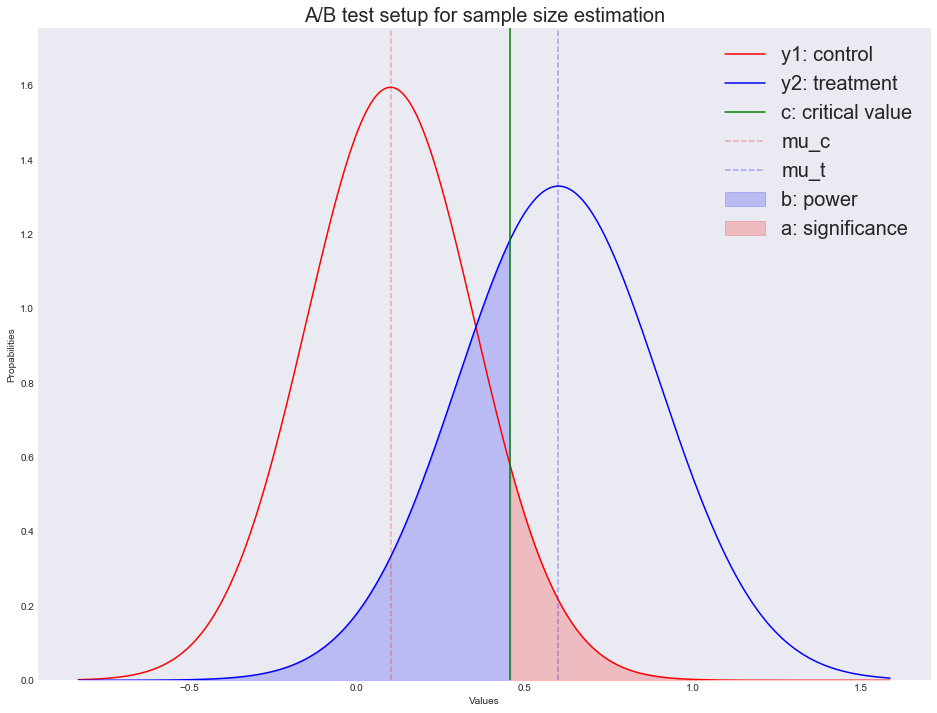

In [11]:
support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots()
ax.plot(support, y1, color='r', label='y1: control')
ax.plot(support, y2, color='b', label='y2: treatment')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: critical value')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='--', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='--', label='mu_t')
ax.fill_between(support[support <= c], 
                y2[support <= c], 
                color='b', alpha=0.2, label='b: power')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: significance')

ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('A/B test setup for sample size estimation', fontsize=20)
ax.set_xlabel('Values')
ax.set_ylabel('Propabilities')

plt.show()

## Selection of sample size

- using quantile function for normal distribution we can calculate position of the theshold

$$\large
c = \mu + t\frac{\sigma}{\sqrt{n}}
$$
- where $t = P\left(X \leq t_\text{level}\right), X \sim \mathcal{N}\left(0, 1\right)$
- we can construct system of two equations, one for each of group

$$\large\left\{ {c = \theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}}\atop c = \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}}} \right.
$$

## Selection of sample size

- Solving previous system for $n$ will give us required number of samples per group with respect to given statistical significance and power

$$\large
\begin{array}{rcl}
\theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}} &=& \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}} \\
\theta_c \sqrt{n} + t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)} &=& \theta_t \sqrt{n} + t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} \\
n &=& \left(\frac{t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} - t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)}}{\theta_c - \theta_t}\right)^2
\end{array}
$$

## Selection of sample size

- to see that it really works let's do one more small exercise
- let's assume that 
 - $\mu_c = 0.001$
 - $\mu_t = 0.0011$
 - $\alpha = \beta = 0.01$
- for such setup we need to send `2 269 319` users to each of variations
- theshold of rejecting $H_0$ will be $c = 0.00104$

In [102]:
def get_size(theta_c, theta_t, alpha, beta):
    # calculate quantiles of normal distribution
    t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    t_beta = stats.norm.ppf(beta, loc=0, scale=1)
    # solve equation for n
    n = t_alpha*np.sqrt(theta_t*(1 - theta_t))
    n -= t_beta*np.sqrt(theta_c*(1 - theta_c))
    n /= theta_c - theta_t
    return int(np.ceil(n*n))

n_max = get_size(0.001, 0.0011, 0.01, 0.01)
print('n =', n_max)
c = 0.001 + stats.norm.ppf(1 - 0.01, loc=0, scale=1)*np.sqrt(0.001*(1 - 0.001)/n_max)
print('c =', c)
theta_c = 0.001
p_value = 1 - stats.norm.cdf(c, loc=theta_c, scale=np.sqrt(theta_c*(1 - theta_c)/n_max))
print('p-value =', p_value)

n = 2269319
c = 0.00104881009215
p-value = 0.01


## Selection of sample size
- we can also draw animation of convergence of two thresholds to one as a function of a sample size

In [13]:
def heavy_plot_function():
    np.random.seed(1342)

    p_c = 0.3 
    p_t = 0.4
    alpha = 0.05
    beta = 0.2

    n_max = get_size(p_c, p_t, alpha, beta)
    c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*np.sqrt(p_c*(1 - p_c)/n_max)
    print(n_max, c)

    def plot_sample_size_frames(do_dorm, width, height):
        left_x = c - width
        right_x = c + width

        n_list = range(5, n_max, 1) + [n_max]
        for f in glob.glob("./../images/sample_size_gif/*_%s.*" % 
                           ('normed' if do_dorm else 'real')):
            os.remove(f)
        for n in tqdm_notebook(n_list):
            s_c = np.sqrt(p_c*(1 - p_c)/n)
            s_t = np.sqrt(p_t*(1 - p_t)/n)

            c_c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*s_c
            c_t = p_t + stats.norm.ppf(beta, loc=0, scale=1)*s_t

            support = np.linspace(left_x, right_x, 1000)
            y_c = stats.norm.pdf(support, loc=p_c, scale=s_c)
            y_t = stats.norm.pdf(support, loc=p_t, scale=s_t)
            if do_dorm:
                y_c /= max(y_c.max(), y_t.max())
                y_t /= max(y_c.max(), y_t.max())

            fig, ax = plt.subplots()
            ax.plot(support, y_c, color='r', label='y control')
            ax.plot(support, y_t, color='b', label='y treatment')

            ax.set_ylim(0, height)
            ax.set_xlim(left_x, right_x)

            ax.axvline(c, color='g', label='c')
            ax.axvline(c_c, color='m', label='c_c')
            ax.axvline(c_t, color='c', label='c_p')
            ax.axvline(p_c, color='r', alpha=0.3, linestyle='--', label='p_c')
            ax.axvline(p_t, color='b', alpha=0.3, linestyle='--', label='p_t')

            ax.fill_between(support[support <= c_t], 
                            y_t[support <= c_t], 
                            color='b', alpha=0.2, label='b: power')
            ax.fill_between(support[support >= c_c], 
                            y_c[support >= c_c], 
                            color='r', alpha=0.2, label='a: significance')

            ax.legend(loc='upper right', prop={'size': 20})

            ax.set_title('Sample size: %i' % n, fontsize=20)

            fig.savefig('./../images/sample_size_gif/%i_%s.png' % 
                        (n, 'normed' if do_dorm else 'real'), dpi=80)

            plt.close(fig)

    plot_sample_size_frames(do_dorm=True, width=0.5, height=1.1)
    plot_sample_size_frames(do_dorm = False, width=1, height=2.5)

    !convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_normed.png; done) -loop 0 ./../images/sample_size_gif/sample_size_normed.gif
    for f in glob.glob("./../images/sample_size_gif/*_normed.png"):
        os.remove(f)

    !convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_real.png; done) -loop 0 ./../images/sample_size_gif/sample_size_real.gif
    for f in glob.glob("./../images/sample_size_gif/*_real.png"):
        os.remove(f)
        
# heavy_plot_function

![Cheated animation](./../images/cheated_conv_ab.gif)

![Correct animation](./../images/conv_ab.gif)

## A/B/n test framework for binary outcomes
- requires:
 - sample mean, sample variance of the CTR and the _lift_ to estimate sample size for the test
   - lift is a level of acceptance of the CTR to change design of the web site
   - if new CTR is greater than old by $0.00001$ and you auditory is 100 persons per day, than maybe it doesn't worth to switch design
 - $\alpha$ and $\beta$, in ideal situation it should be determined by marketing department (if they do not understand this concept, than explaining would became most hardest part of A/B test)
- outcome:
 - if test favors an alternative hypothesis, than we are happy, but still there are $\alpha \cdot 100\%$ and $\beta \cdot 100\%$ chances of an errors
 - if outcome is for not rejecting null hypothesis, than we will be very upset; actually, it doesn't say us that new colour works bad, just that _given all condition there are no evidence to reject_ $H_0$ (maybe if lift would be a bit less than we could reject $H_0$)
- ...too many conditions and too poor outcome...

## A/B/n test framework for binary outcomes
- if you still remember, we actually have <font color="red">four</font> <font color="green">different</font> <font color="blue">button</font> <font color="orange">colors</font>, it means that we have four alternative hypotheses
- to handle this problem we can split users into 5 groups, one control and four treatment groups
- first issue here is that we can not test all of them vs each other, the test is four alternative vs one control
 - at the end of a day if you have that two of them perform better then control, then you will need to run one more test between these two hypotheses
- second issue is with sample size, again

## Bonferroni correction

- given statistical significance level $\alpha = P\left(H_1 \mid H_0\right)$ and two events:
 - $A$: `the probability of rejecting at least one true hypothesis`
 - $B$: `making at least one type I error`

$$\large\begin{array}{rcl}
P\left(A\right) &=& 1 - P\left(B\right) \\
&=& 1 - \left(1 - 0.05\right)^5 \\
&=& 1 - 0.95^5 \\
&\approx& 0.2262
\end{array}$$

- magically $5\%$ becomes $22.62\%$ 

![WAT](./../images/wat.png)

## Bonferroni correction

- let's try to divide original $\alpha$ level to the number of variations

$$\large\begin{align}
P \left({ \bigcup_{i=1}^{n}\left( p_i<\frac{\alpha}{n}\right) }\right) &\le \sum_{i=1}^{n}P\left(p_i<\frac{\alpha}{n}\right)\\
&\le \sum_{i=1}^{n}\frac{\alpha}{n}\\
&= n \frac{\alpha}{n}\\
&= \alpha
\end{align}$$

## Bonferroni correction

- let's chech this trick

$$\large\begin{array}{rcl}
P\left(A\right) &=& 1 - P\left(B\right) \\
&=& 1 - \left(1 - 0.01\right)^5 \\
&=& 1 - 0.99^5 \\
&\approx& 0.0491
\end{array}$$

- lets recalculate sample size for previouse example, before it was $n = 2269319$

In [15]:
n_max = get_size(0.001, 0.0011, 0.01/5, 0.01)
print('n =', n_max)

n = 2853873


## Zombi-salmon (???)

- <a href="http://prefrontal.org/files/posters/Bennett-Salmon-2009.pdf">in 2012 Ig Nobel Prize</a> was given to the group of scientists

```
Subject. One mature Atlantic Salmon (Salmo salar) 
participated in the fMRI study. The salmon was 
approximately 18 inches long, weighed 3.8 lbs, 
and was not alive at the time of scanning.

Task. The task administered to the salmon involved 
completing an open-ended mentalizing task. The 
salmon was shown an series of photographs depicting 
human individuals in social situations with a 
specified emotional valence. The salmon was asked 
to determine what emotion the individual in the 
photo must have been experiencing.
```

Salmon (dead) | Resurrection machine
-----------------|------------
<img src="./../images/salmon.jpg" width="420" /> | <img src="./../images/mri.jpg" width="420" />

<img src="./../images/salmon_dead.png" width="420" />

- given significance level $p=0.001$ they have got an activity in 16 of 8064 voxels, which is quite good for a dead fish
- authors also have shown that up to $40\%$ of papers in neurobiology ignored Bonferonni correction before 2010, after their publication this ratio reduced to $10\%$

## Quiz

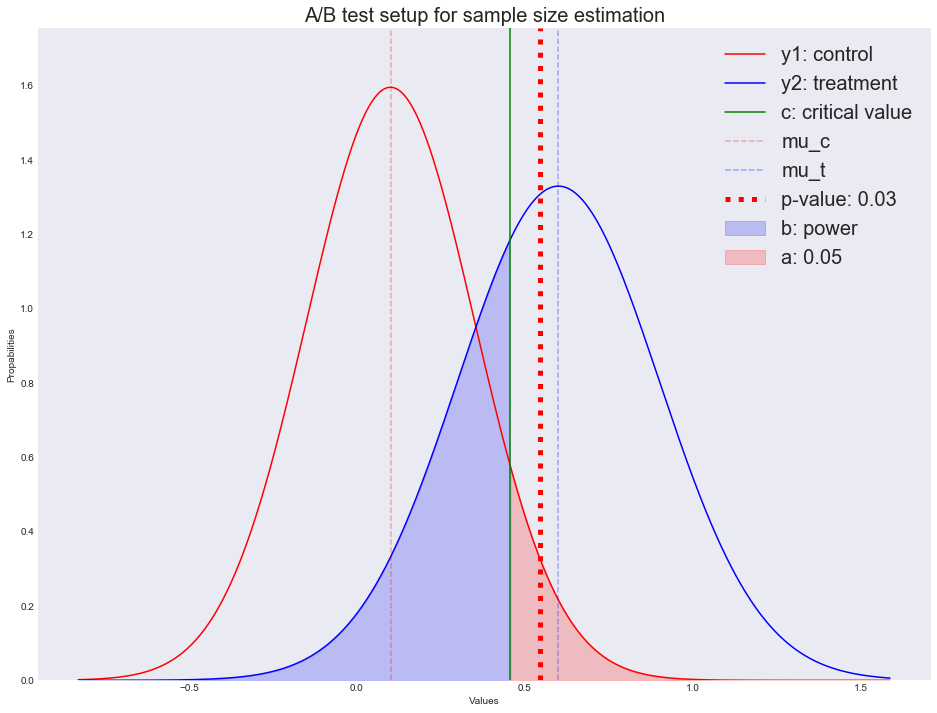

In [109]:
# mean values
mu_c = 0.1
mu_t = 0.6

# standard deviations
s_c = 0.25
s_t = 0.3

# threshold
c = 1.3*(mu_c + mu_t)/2

support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots()
ax.plot(support, y1, color='r', label='y1: control')
ax.plot(support, y2, color='b', label='y2: treatment')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: critical value')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='--', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='--', label='mu_t')
ax.fill_between(support[support <= c], 
                y2[support <= c], 
                color='b', alpha=0.2, label='b: power')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: 0.05')

ax.axvline(c + 0.09, color='r', alpha=1, linestyle=':', label='p-value: 0.03', linewidth=5)

ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('A/B test setup for sample size estimation', fontsize=20)
ax.set_xlabel('Values')
ax.set_ylabel('Propabilities')

plt.show()

## Final slide about A/B/n tests (???)

You've run an A/B test, you've got CTR value such that p-value $P\left(\text{CTR}_\text{true} > \text{CTR}_\text{observed} \mid H_0\right) = 0.03$. Which of the following is true?

- $H_0$ is rejected (that is, there is no difference between the variations).
- the probability of the null hypothesis being true is 0.03
- $H_1$ is proved (that the variation is better than the control).
- the probability of the variation being better than control is 97%.
- if you decide to reject the $H_0$, the probability that you are making the wrong decision is 3%.
- if the experiment were repeated a great number of times, you would obtain a significant result on 97% of occasions.

## The last slide about A/B/n tests

Besides problems with interpretation and explanation results to the marketing there several other problems:

- A/B/n tests doesn't yake into account seasonality, and the only way is to repeat tests continuously
- we are not optimizing what is needed to a business, business doesn't need to know what button brings more click, business wants more money
- given two variations we spend N users for each of them, but we know in advance that one of them is better, we would like to spend more users for the winning variation and less for worse one (unfortunately we doesn't know which of them is better)
- you can think of other disadvantages

Good news is that there is solution for most of the cases - Bayesian multi-armed bandits

# Recap of bayesian inference

![WAT](./../images/bayes_app.png)

$$\Large \color{green}{p\left(y \mid x\right)} = \dfrac{\color{orange}{p\left(x \mid y\right)} \color{blue}{p\left(y\right)}}{\color{red}{p\left(x\right)}}$$

where:
- $\large \color{blue}{p\left(y\right)}$
  - Prior: how probable was our hypothesis before observing the evidence?
- $\large \color{orange}{p\left(x \mid y\right)}$
  - Likelihood: how probable is the evidence given that our hypothesis is true?
- $\large \color{red}{p\left(x\right) = \sum_{z} p\left(x \mid z\right) p\left(z\right)}$
  - Marginal: how probable is the new evidence under all possible hypothesis?
- $\large \color{green}{p\left(y \mid x\right)}$
  - Posterior: how probable is our hypothesis given the observed evidence?

# Bayesian multi-armed bandits for online experimens

- Multi-armed bandits (MAB) are not replacement for testing
- goal of the hypothesis testing is to reject null hypothesis in a favor to alternative (meicine, phisics, etc)
- goal of MAB is to optimize the revenue